# Figure. CNV eQTLs

In [1]:
import copy
import cPickle
import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_cnv_eqtls'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.

In [2]:
fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'sig_not_genic_vs_not_sig_roadmap_res.tsv')
intergenic_res = pd.read_table(fn, index_col=0)

repressive = ['H3K9me3', 'H3K27me3']
transcribed = ['H3K36me3']
intergenic_res['type'] = 'Active'
for i in repressive:
    intergenic_res.ix[intergenic_res.mark == i, 'type'] = 'Repressive'
for i in transcribed:
    intergenic_res.ix[intergenic_res.mark == i, 'type'] = 'Transcribed'

intergenic_res['mark_mean'] = np.nan
for m in set(intergenic_res.mark):
    ind = intergenic_res[intergenic_res.mark == m].index
    intergenic_res.ix[ind, 'mark_mean'] = intergenic_res.ix[ind, 'neg_log_pvalue'].mean()

intergenic_res.sort_values(by=['type', 'mark_mean'], inplace=True, ascending=[True, False])

In [3]:
fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'sig_genic_vs_not_sig_roadmap_res.tsv')
genic_res = pd.read_table(fn, index_col=0)

repressive = ['H3K9me3', 'H3K27me3']
transcribed = ['H3K36me3']
genic_res['type'] = 'Active'
for i in repressive:
    genic_res.ix[genic_res.mark == i, 'type'] = 'Repressive'
for i in transcribed:
    genic_res.ix[genic_res.mark == i, 'type'] = 'Transcribed'

genic_res['mark_mean'] = np.nan
for m in set(genic_res.mark):
    ind = genic_res[genic_res.mark == m].index
    genic_res.ix[ind, 'mark_mean'] = genic_res.ix[ind, 'neg_log_pvalue'].mean()

genic_res.sort_values(by=['type', 'mark_mean'], inplace=True, ascending=[True, False])

In [4]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/combined_info.pickle')
combined_info = cPickle.load(open(fn))
combined_info = combined_info[combined_info.emmax]

In [5]:
fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'cnv_gene_variants.pickle')
cnv_gv = pd.read_pickle(fn)

fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'lead_variants.pickle')
lead_vars = pd.read_pickle(fn)

In [6]:
sns.set_style('whitegrid')

In [7]:
cnv_lead_vars = cnv_gv[cnv_gv.cnv_is_lead]
cnv_lead_vars = cnv_lead_vars.sort_values(by='pvalue').drop_duplicates(subset=['gene_id'])

In [8]:
cnv_abs_beta_pdf = pd.Series(index=np.arange(0, 3 + 0.1, 0.1))
se = cnv_lead_vars.drop_duplicates('gene_id').beta.abs()
density = stats.gaussian_kde(se)
cnv_abs_beta_pdf = pd.Series(density(cnv_abs_beta_pdf.index), index=cnv_abs_beta_pdf.index)
snv_abs_beta_pdf = pd.DataFrame(index=np.arange(0, 3 + 0.005, 0.005))
se = lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.abs()
density = stats.gaussian_kde(se)
snv_abs_beta_pdf = pd.Series(density(snv_abs_beta_pdf.index), index=snv_abs_beta_pdf.index)

In [16]:
vc = (lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta > 0).value_counts()
p = stats.binom_test(vc)
print('{:.2f}% of lead variants for genes with no significant CNV have \n'
      'negative betas (p={:.5f}, binomial test).'.format(100 * vc[False] / float(vc.sum()), p))
print('')

52.27% of lead variants for genes with no significant CNV have 
negative betas (p=0.00091, binomial test).



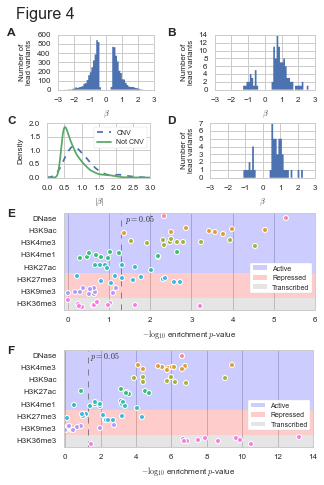

In [18]:
bcolor = (0.29803921568627451, 0.44705882352941179, 0.69019607843137254, 1.0)
bins = np.arange(-3, 3.1, 0.1)

fig = plt.figure(figsize=(4.48, 6.8), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 4',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.95, 0.5, 1])

# eGenes, no significant CNV.
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled', lw=0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of\nlead variants', fontsize=8)
ax.yaxis.set_major_formatter(ciepy.comma_format)
ax.set_xlim(-3, 3)
gs.tight_layout(fig, rect=[0, 0.73, 0.5, 0.95])

# eGenes with CNV lead variants
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_lead_vars.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled', lw=0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of\nlead variants', fontsize=8)
ax.set_xlim(-3, 3)
gs.tight_layout(fig, rect=[0.5, 0.73, 1, 0.95])

# Absolute value effect size PDFs
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_abs_beta_pdf.plot(label='CNV', ax=ax, linestyle='--')
snv_abs_beta_pdf.plot(label='Not CNV', ax=ax)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\left|\\beta\\right|$', fontsize=8)
ax.set_ylabel('Density', fontsize=8)
ax.legend(fontsize=7, frameon=True, fancybox=True)
gs.tight_layout(fig, rect=[0, 0.55, 0.5, 0.77])

# Lead variant CNV not overlapping gene
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
g = cnv_lead_vars.ix[cnv_lead_vars.cnv_overlaps_gene_cons, 'gene_id']
t = cnv_lead_vars[cnv_lead_vars.gene_id.apply(lambda x: x not in g.values)]
t.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled', lw=0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of\nlead variants', fontsize=8)
ax.set_xlim(-3, 3)
gs.tight_layout(fig, rect=[0.5, 0.55, 1, 0.77])

# Functional enrichment for intergenic CNVs.
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
sns.stripplot(x='neg_log_pvalue', y='mark', data=intergenic_res, jitter=0.3, 
              ax=ax, orient='h', size=5)
for t in ax.get_xticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$-\\log_{10}$ enrichment $p$-value', fontsize=8)
xmin,xmax = ax.get_xlim()
ax.set_xlim(-0.1, xmax)
ymin,ymax = ax.get_ylim()
ax.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', color='grey',
          linewidth=1)
ax.text(-np.log10(0.05) + 0.1, ymax, '$p=0.05$', ha='left', va='top', fontsize=8)
ax.axhspan(-0.5, 4.5, facecolor='blue', alpha=0.2, label='Active', lw=0)
ax.axhspan(4.5, 6.5, facecolor='red', alpha=0.2, label='Repressed', lw=0)
ax.axhspan(6.5, 7.5, facecolor='grey', alpha=0.2, label='Transcribed', lw=0)
ax.legend(frameon=True, fancybox=True, loc=[0.74, 0.17], fontsize=7)
ax.set_ylabel('')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.28, 1, 0.58])

# Functional enrichment for genic CNVs.
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
sns.stripplot(x='neg_log_pvalue', y='mark', data=genic_res, jitter=0.3, 
              ax=ax, orient='h', size=5)
for t in ax.get_xticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$-\\log_{10}$ enrichment $p$-value', fontsize=8)
xmin,xmax = ax.get_xlim()
ax.set_xlim(-0.1, xmax)
ymin,ymax = ax.get_ylim()
ax.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', color='grey',
          linewidth=1)
ax.text(-np.log10(0.05) + 0.1, ymax, '$p=0.05$', ha='left', va='top', fontsize=8)
ax.axhspan(-0.5, 4.5, facecolor='blue', alpha=0.2, label='Active', lw=0)
ax.axhspan(4.5, 6.5, facecolor='red', alpha=0.2, label='Repressed', lw=0)
ax.axhspan(6.5, 7.5, facecolor='grey', alpha=0.2, label='Transcribed', lw=0)
ax.legend(frameon=True, fancybox=True, loc=[0.74, 0.17], fontsize=7)
ax.set_ylabel('')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0, 1, 0.3])

t = fig.text(0.005, 0.92, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.92, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.74, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.74, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.55, 'E', weight='bold', 
             size=12)
t = fig.text(0.005, 0.27, 'F', weight='bold', 
             size=12)

fig.savefig(os.path.join(outdir, 'cnv_eqtls.pdf'))
fig.savefig(os.path.join(outdir, 'cnv_eqtls.png'), dpi=300)

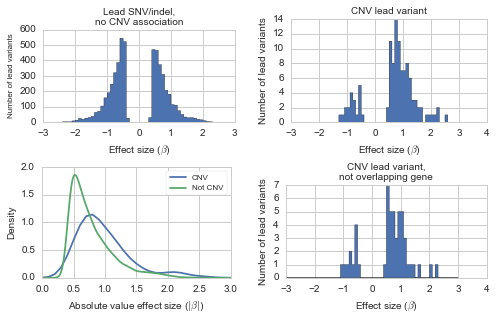

In [11]:
fs = 10

bcolor = (0.29803921568627451, 0.44705882352941179, 0.69019607843137254, 1.0)
bins = np.arange(-3, 3.1, 0.1)

fig = plt.figure(figsize=(7, 4.5), dpi=300)

# eGenes, no significant CNV.
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Effect size ($\\beta$)', fontsize=fs)
ax.set_ylabel('Number of lead variants', fontsize=8)
ax.yaxis.set_major_formatter(ciepy.comma_format)
ax.set_xlim(-3, 3)
ax.set_title('Lead SNV/indel,\nno CNV association', fontsize=fs)
gs.tight_layout(fig, rect=[0, 0.48, 0.5, 1])

# eGenes with CNV lead variants
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_lead_vars.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Effect size ($\\beta$)', fontsize=fs)
ax.set_ylabel('Number of lead variants', fontsize=fs)
ax.set_title('CNV lead variant', fontsize=fs)
ax.set_xlim(-3, 3)
gs.tight_layout(fig, rect=[0.5, 0.48, 1, 1])

# Absolute value effect size PDFs
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_abs_beta_pdf.plot(label='CNV', ax=ax)
snv_abs_beta_pdf.plot(label='Not CNV', ax=ax)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Absolute value effect size ($\\left|\\beta\\right|$)', fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)
ax.legend(fontsize=8, frameon=True, fancybox=True)
ax.set_xlim(-3, 3)
gs.tight_layout(fig, rect=[0, 0, 0.5, 0.52])

# Lead variant CNV not overlapping gene
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
g = cnv_lead_vars.ix[cnv_lead_vars.cnv_overlaps_gene_cons, 'gene_id']
t = cnv_lead_vars[cnv_lead_vars.gene_id.apply(lambda x: x not in g.values)]
t.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Effect size ($\\beta$)', fontsize=fs)
ax.set_ylabel('Number of lead variants', fontsize=fs)
ax.set_title('CNV lead variant,\nnot overlapping gene', fontsize=fs)
gs.tight_layout(fig, rect=[0.5, 0, 1, 0.52])

fig.savefig(os.path.join(outdir, 'cnv_eqtls_presentation.pdf'))

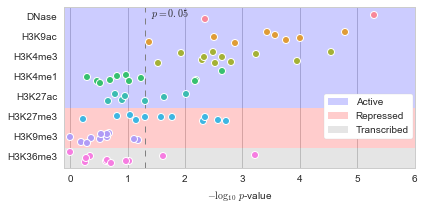

In [12]:
fig,ax = plt.subplots(1, 1, figsize=(6, 3))
sns.stripplot(x='neg_log_pvalue', y='mark', data=intergenic_res, jitter=0.3, 
              ax=ax, orient='h')
for t in ax.get_xticklabels():
    t.set_fontsize(10)
ax.set_xlabel('$-\\log_{10}$ $p$-value', fontsize=10)
xmin,xmax = ax.get_xlim()
ax.set_xlim(-0.1, xmax)
ymin,ymax = ax.get_ylim()
ax.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', color='grey',
          linewidth=1)
ax.text(-np.log10(0.05) + 0.1, ymax, '$p=0.05$', ha='left', va='top')
ax.axhspan(-0.5, 4.5, facecolor='blue', alpha=0.2, label='Active', lw=0)
ax.axhspan(4.5, 6.5, facecolor='red', alpha=0.2, label='Repressed', lw=0)
ax.axhspan(6.5, 7.5, facecolor='grey', alpha=0.2, label='Transcribed', lw=0)
ax.legend(frameon=True, fancybox=True, loc=[0.74, 0.18])
ax.set_ylabel('')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'intergenic_enrichment.pdf'))

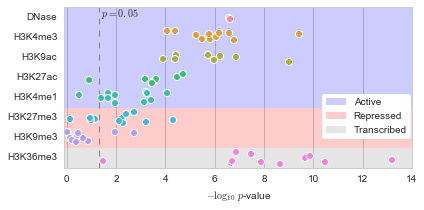

In [13]:
fig,ax = plt.subplots(1, 1, figsize=(6, 3))
sns.stripplot(x='neg_log_pvalue', y='mark', data=genic_res, jitter=0.3, 
              ax=ax, orient='h')
for t in ax.get_xticklabels():
    t.set_fontsize(10)
ax.set_xlabel('$-\\log_{10}$ $p$-value', fontsize=10)
xmin,xmax = ax.get_xlim()
ax.set_xlim(-0.1, xmax)
ymin,ymax = ax.get_ylim()
ax.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', color='grey',
          linewidth=1)
ax.text(-np.log10(0.05) + 0.1, ymax, '$p=0.05$', ha='left', va='top')
ax.axhspan(-0.5, 4.5, facecolor='blue', alpha=0.2, label='Active', lw=0)
ax.axhspan(4.5, 6.5, facecolor='red', alpha=0.2, label='Repressed', lw=0)
ax.axhspan(6.5, 7.5, facecolor='grey', alpha=0.2, label='Transcribed', lw=0)
ax.legend(frameon=True, fancybox=True, loc=[0.74, 0.18])
ax.set_ylabel('')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'genic_enrichment.pdf'))